In [ ]:
# colab上运行 kaggle参赛CIFAR-10 - Object Recognition in Images

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
keras.api._v2.keras 2.8.0


In [3]:
!cat /proc/cpuinfo
!nvidia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import json

token = {"username": "liumars", "key": "95ab3c9193f271bf8e3bfe6c7f3d8f5a"}
with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

In [11]:
!cat /content/kaggle.json
!pwd

{"username": "liumars", "key": "95ab3c9193f271bf8e3bfe6c7f3d8f5a"}/content


In [18]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [20]:
# !kaggle datasets download -d slothkong/10-monkey-species
!kaggle competitions download -c cifar-10

 96% 689M/715M [00:17<00:01, 26.9MB/s]
100% 715M/715M [00:17<00:00, 42.8MB/s]


In [29]:
!ls /content/competitions/cifar-10
!unzip /content/competitions/cifar-10/cifar-10.zip

cifar-10.zip
Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [30]:
%pip install py7zr
import py7zr

a = py7zr.SevenZipFile(r'./train.7z', 'r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()
!ls /content/competitions/cifar-10/train |wc -l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
50000


In [31]:
a = py7zr.SevenZipFile(r'./test.7z', 'r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()
!ls /content/competitions/cifar-10/test |wc -l

300000


In [32]:
!cp sampleSubmission.csv trainLabels.csv /content/competitions/cifar-10
!ls /content/competitions/cifar-10

cifar-10.zip  sampleSubmission.csv  test  train  trainLabels.csv


In [37]:
# 所有类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck', ]
train_labels_file = '/content/competitions/cifar-10/trainLabels.csv'
test_csv_file = '/content/competitions/cifar-10/sampleSubmission.csv'
train_folder = '/content/competitions/cifar-10/train'
test_folder = '/content/competitions/cifar-10/test'


def parse_csv_file(filepath, folder):
    results = []  # [(filename(path), label)] flow_from_dataframe要求格式
    # 读取所有行
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

# 解析对应的文件夹
train_labels_info = parse_csv_file(train_labels_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

In [38]:
import pprint
pprint.pprint(train_labels_info[:5])
pprint.pprint(test_csv_info[:5])
print(len(train_labels_info), len(test_csv_file))

[('/content/competitions/cifar-10/train/1.png', 'frog'),
 ('/content/competitions/cifar-10/train/2.png', 'truck'),
 ('/content/competitions/cifar-10/train/3.png', 'truck'),
 ('/content/competitions/cifar-10/train/4.png', 'deer'),
 ('/content/competitions/cifar-10/train/5.png', 'automobile')]
[('/content/competitions/cifar-10/test/1.png', 'cat'),
 ('/content/competitions/cifar-10/test/2.png', 'cat'),
 ('/content/competitions/cifar-10/test/3.png', 'cat'),
 ('/content/competitions/cifar-10/test/4.png', 'cat'),
 ('/content/competitions/cifar-10/test/5.png', 'cat')]
50000 51


In [39]:
train_df = pd.DataFrame(train_labels_info[:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)
# 给df赋列索引名
train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']
print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                     filepath       class
0  /content/competitions/cifar-10/train/1.png        frog
1  /content/competitions/cifar-10/train/2.png       truck
2  /content/competitions/cifar-10/train/3.png       truck
3  /content/competitions/cifar-10/train/4.png        deer
4  /content/competitions/cifar-10/train/5.png  automobile
                                         filepath       class
0  /content/competitions/cifar-10/train/45001.png       horse
1  /content/competitions/cifar-10/train/45002.png  automobile
2  /content/competitions/cifar-10/train/45003.png        deer
3  /content/competitions/cifar-10/train/45004.png  automobile
4  /content/competitions/cifar-10/train/45005.png    airplane
                                    filepath class
0  /content/competitions/cifar-10/test/1.png   cat
1  /content/competitions/cifar-10/test/2.png   cat
2  /content/competitions/cifar-10/test/3.png   cat
3  /content/competitions/cifar-10/test/4.png   cat
4  /content/competitions/

In [40]:
!ls competitions/cifar-10/train/1.png

competitions/cifar-10/train/1.png


In [41]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10
# 超参数
train_data_gene = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_data_gene.flow_from_dataframe(
    train_df,
    directory='./',
    x_col='filepath',
    y_col='class',
    classes=class_names,
    target_size=(height, width),
    batch_size=batch_size,
    seed=7, shuffle=True,
    class_mode='sparse')

Found 45000 validated image filenames belonging to 10 classes.


In [44]:
valid_data_gene = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_data_gene.flow_from_dataframe(
    valid_df,
    directory='./',
    x_col='filepath',
    y_col='class',
    classes=class_names,
    target_size=(height, width),
    batch_size=batch_size,
    seed=7, shuffle=True,
    class_mode='sparse')
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [47]:
for _ in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [49]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3,padding='same',
                        activation='selu', input_shape=[height, width, channels]),  
    keras.layers.BatchNormalization(),# 加快模型的收敛速度
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'), ])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam', metrics=['accuracy'])

In [50]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                        

In [51]:
epochs = 100
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_num // batch_size,
                              epochs=epochs,
                              validation_data=valid_generator,
                              validation_steps=valid_num // batch_size, )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
1406/1406 [==============================] - 68s 40ms/step - loss: 1.9453 - accuracy: 0.3456 - val_loss: 1.4477 - val_accuracy: 0.4840
Epoch 2/100
1406/1406 [==============================] - 50s 36ms/step - loss: 1.4774 - accuracy: 0.4693 - val_loss: 1.4051 - val_accuracy: 0.5144
Epoch 3/100
1406/1406 [==============================] - 51s 37ms/step - loss: 1.2866 - accuracy: 0.5426 - val_loss: 1.2599 - val_accuracy: 0.5913
Epoch 4/100
1406/1406 [==============================] - 52s 37ms/step - loss: 1.1213 - accuracy: 0.6075 - val_loss: 0.9442 - val_accuracy: 0.6911
Epoch 5/100
1406/1406 [==============================] - 52s 37ms/step - loss: 0.9912 - accuracy: 0.6553 - val_loss: 0.8308 - val_accuracy: 0.7334
Epoch 6/100
1406/1406 [==============================] - 51s 36ms/step - loss: 0.8960 - accuracy: 0.6936 - val_loss: 0.8391 - val_accuracy: 0.7384
Epoch 7/100
1406/1406 [==============================] - 52s 37ms/step - loss: 0.8174 - accuracy: 0.7210 - val_loss: 0

In [52]:
print(history.history)

{'loss': [1.9453173875808716, 1.477442979812622, 1.2866032123565674, 1.121250033378601, 0.9911822080612183, 0.8959681391716003, 0.8174168467521667, 0.7625849843025208, 0.7081366181373596, 0.6682456731796265, 0.6372206211090088, 0.5935348868370056, 0.5743998885154724, 0.5455139875411987, 0.530177891254425, 0.5042279362678528, 0.48654237389564514, 0.4764849841594696, 0.4611413776874542, 0.4515669345855713, 0.4352932572364807, 0.4263518750667572, 0.4097957909107208, 0.39650943875312805, 0.3904576003551483, 0.38351938128471375, 0.37436044216156006, 0.3628559112548828, 0.3605751097202301, 0.3528996407985687, 0.3454456031322479, 0.3376850187778473, 0.3262384235858917, 0.3178013563156128, 0.314008891582489, 0.31076017022132874, 0.30328625440597534, 0.2970265746116638, 0.2900237441062927, 0.28946584463119507, 0.28125518560409546, 0.2777513563632965, 0.2775837182998657, 0.2643892765045166, 0.26713111996650696, 0.26167017221450806, 0.2570858597755432, 0.2523505687713623, 0.24655455350875854, 0.2

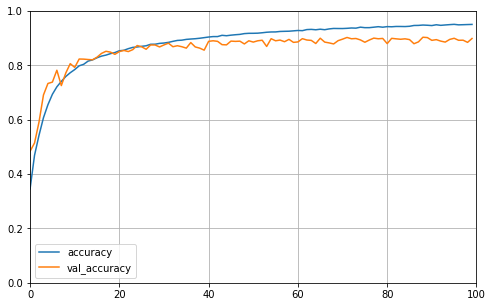

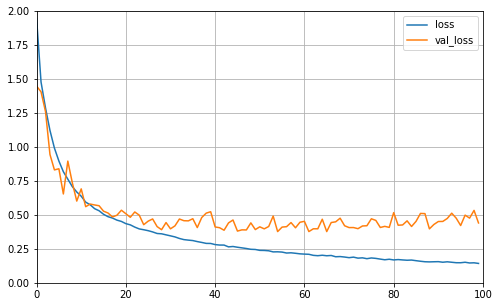

In [53]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_' + label] = history.history['val_' + label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()


plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [54]:
# 测试集
test_data_gene = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
test_generator = test_data_gene.flow_from_dataframe(
    test_df,
    directory='./',
    x_col='filepath',
    y_col='class',
    classes=class_names,
    target_size=(height, width),
    batch_size=batch_size,
    seed=7, shuffle=False,
    class_mode="sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [55]:
test_predict = model.predict_generator(test_generator,
                                       workers=-1,
                                       use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
print(test_predict.shape)
print(test_predict[:5])

(300000, 10)
[[5.4774823e-04 3.0908056e-02 1.0418328e-04 1.7762645e-04 2.5695163e-05
  6.3072883e-05 2.0423498e-04 4.7239049e-05 1.9138951e-04 9.6773082e-01]
 [1.7332546e-01 1.8664385e-01 1.0161486e-01 1.0153587e-02 2.5270123e-03
  4.7812201e-03 2.4184436e-03 4.4260528e-03 4.9327430e-01 2.0835212e-02]
 [4.9563744e-13 9.9999988e-01 2.3630165e-16 2.9359330e-17 2.4769321e-22
  2.6790963e-18 3.0708362e-19 1.1679799e-18 2.0690970e-14 6.9782239e-08]
 [2.2184689e-04 2.1802462e-07 5.8774681e-08 9.9416035e-08 6.7232437e-09
  5.4190405e-08 7.8998417e-09 2.4562087e-08 9.9977738e-01 3.9673344e-07]
 [9.9999392e-01 1.0534560e-07 5.5124974e-07 6.8075806e-08 7.4662758e-08
  1.8272824e-07 2.6879505e-07 2.0157945e-07 3.8274757e-06 7.8496618e-07]]


In [57]:
# 最大值的下标
test_predict_class_indices = np.argmax(test_predict, axis=1)
print(test_predict_class_indices[:5])

[9 8 1 8 0]


In [58]:
test_predict_class = [class_names[index] for index in test_predict_class_indices]
print(test_predict_class[:5])

['truck', 'ship', 'automobile', 'ship', 'airplane']


In [61]:
# 最终提交结果
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write(f'{i + 1},{predict_class[i]}\n')


output_file = './submission.csv'
generate_submissions(output_file, test_predict_class)

In [62]:
!kaggle competitions submit -c cifar-10 -f submission.csv -m "Liu"

100% 3.59M/3.59M [00:04<00:00, 843kB/s] 
Successfully submitted to CIFAR-10 - Object Recognition in Images